<a href="https://colab.research.google.com/github/martin23-sg/MFyVI_Proyecto/blob/main/Proyecto_MFyVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROYECTO: OPTIMIZACIÓN DE PORTAFOLIOS CON MARKOWITZ.**

###**Integrantes:**

Mauricio Abundez

Huitzil Sánchez

Martin Sierra

Emiliano Vázquez


In [1]:
# Paqueterias utilizadas:
import yfinance as yf
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import math
import requests

### **Descarga de Información y Conversión a Pesos Mexicanos de los Activos Seleccionados y del *SPX*.**

In [2]:
# Parámetros para la descarga de información
inicio = datetime.date(2010,1,1) # Fecha inicial de la descarga del histórico de precios
fin = datetime.date.today().strftime('%Y-%m-%d') # Fecha final de la descarga del histórico de precios
tickers = ['XLE','XLK', 'XLU', 'XLV'] # Selección de activos (que cotizen en el mercado estadounidense)
tc = 'USDMXN=X' # Tipo de cambio a usar: Dólar (USD) a Peso Mexicano (MXN)

In [3]:
## Descarga de los precios de 4 ETF´s de Yahoo Finance en pesos mexicanos:

# Descarga del histórico de los precios de cierre de los 4 ETF´s
precios = yf.download(tickers = tickers, start = inicio, end = fin)['Close']

# Descarga del histórico del tipo de cambio entre el dólar y el peso mexicano
tipo_cambio = yf.download(tc, start=inicio, end=fin, interval='1d')['Close']

# Unión de los dataFrames anteriores
precios = precios.join(tipo_cambio, how='inner')

# Cálculo de los precios de cierre en pesos mexicanos
for i in range(len(tickers)):
  precios[tickers[i]] = precios[tickers[i]]*precios[tc]

del precios[tc] # Eliminación de la columna 'tc' del DataFrame 'precios'

/tmp/ipython-input-3502214104.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  precios = yf.download(tickers = tickers, start = inicio, end = fin)['Close']
[*********************100%***********************]  4 of 4 completed
/tmp/ipython-input-3502214104.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tipo_cambio = yf.download(tc, start=inicio, end=fin, interval='1d')['Close']
[*********************100%***********************]  1 of 1 completed


In [4]:
## Descarga de la información del SPX de Yahoo Finance en pesos mexicanos:

# Descarga del histórico de los precios de cierre del SPX
spx = yf.download('^SPX', start=inicio, end=fin)['Close']

# Unión del dataFrame con 'tipo_cambio'
spx = spx.join(tipo_cambio, how='inner', lsuffix='_etf', rsuffix='_mxn')

# Cálculo del precio de cierre en pesos mexicanos
spx['^SPX'] = spx['^SPX']*spx[tc]

del spx[tc] # Eliminación de la columna 'tc' del DataFrame 'spx'

# DataFrame con el histórico de los precios de cierre del SPX en pesos mexicanos:
#spx.tail(10)

/tmp/ipython-input-212176783.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spx = yf.download('^SPX', start=inicio, end=fin)['Close']
[*********************100%***********************]  1 of 1 completed


### **Cálculo de rendimientos.**

In [5]:
# Cálculo de los rendimientos diarios de los activos elegidos:
rend_diario = precios/precios.shift(1)-1

In [6]:
# Cálculo de los rendimientos anualizados de los activos elegidos
rend_anualizados = ((1+rend_diario).rolling(252).apply(np.prod))-1
rend_anualizados.tail(5) # Últimas observaciones

Ticker,XLE,XLK,XLU,XLV
Date,,,,
2026-02-03,0.003839,0.043745,-0.037714,-0.098025
2026-02-04,0.038820,0.004134,-0.051202,-0.098616
2026-02-05,0.001343,-0.019000,-0.073328,-0.125440
2026-02-06,0.049536,0.055810,-0.013387,-0.062848
2026-02-09,0.033361,0.036028,-0.040367,-0.098799


In [7]:
# Rendimientos diarios del SPX
rend_diario_spx = spx/spx.shift(1) - 1

In [8]:
# Rendimientos anualizados del SPX
rend_anualizados_spx =((1+rend_diario_spx).rolling(252).apply(np.prod))-1
rend_anualizados_spx.tail(5) # Últimas observaciones

Ticker,^SPX
Date,
2026-02-03,-0.034313
2026-02-04,-0.049947
2026-02-05,-0.071893
2026-02-06,-0.014159
2026-02-09,-0.033624


### **Visualizaciones.**

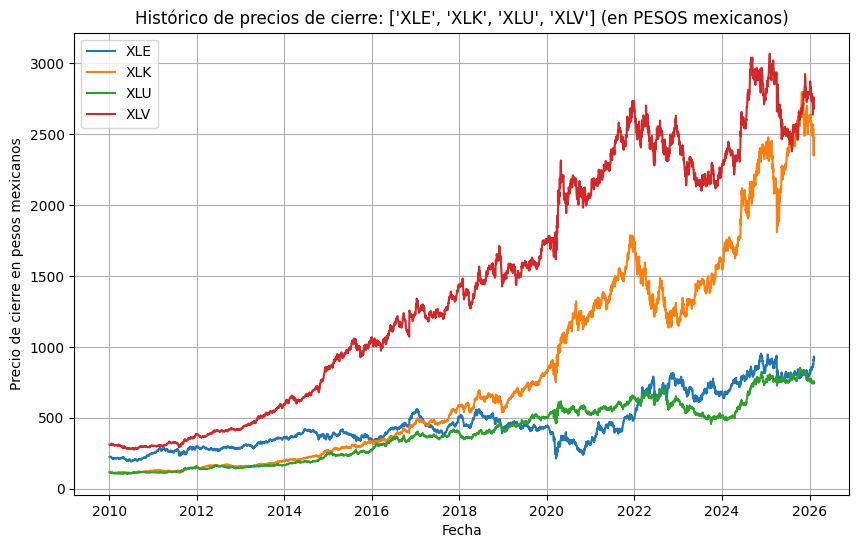

In [9]:
# Visualización de los precios de cierre para los activos seleccionados en pesos mexicanos
plt.figure(figsize=(10, 6))
plt.plot(precios)
plt.title(f'Histórico de precios de cierre: {tickers} (en PESOS mexicanos)')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre en pesos mexicanos')
plt.legend(precios.columns)
plt.grid(True)
plt.show()

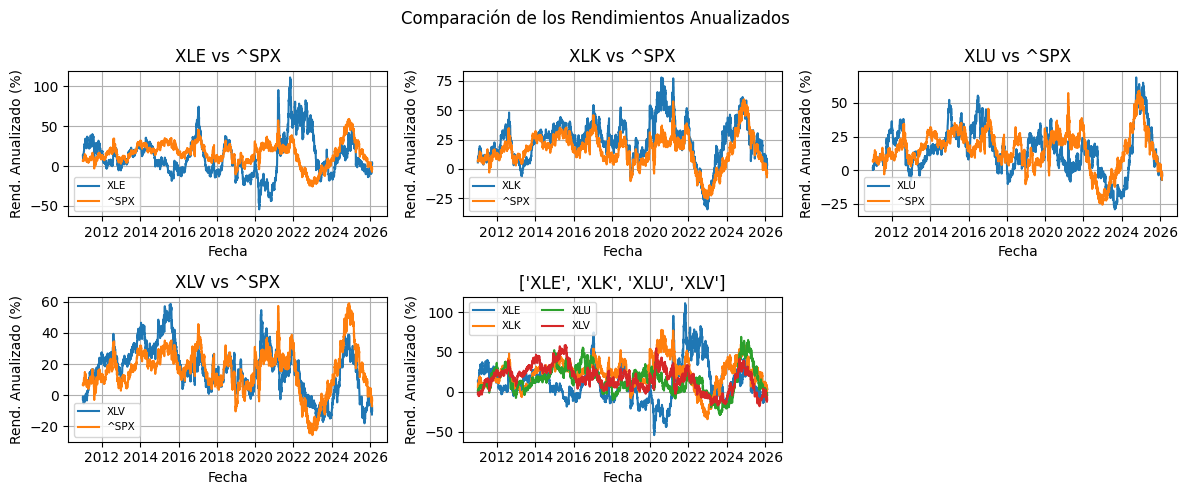

In [10]:
# Visualización de rendimientos anualizados:
columnas = 3 # Número de columnas en la gráfica
renglones = math.ceil((len(tickers)+1)/columnas) # Número de renglones en la gráfica
# Gráfica
figure,axs = plt.subplots(renglones, columnas, figsize = (columnas*4,renglones*2.5))
figure.suptitle('Comparación de los Rendimientos Anualizados')
aux = 0
for j in range(renglones):
  for i in range(columnas):
    if aux < len(tickers):
      activo = rend_anualizados.columns[aux]
      axs[j,i].plot(rend_anualizados[activo]*100)
      axs[j,i].plot(rend_anualizados_spx['^SPX']*100)
      axs[j,i].set_title(f'{rend_anualizados.columns[aux]} vs ^SPX')
      axs[j,i].set_xlabel('Fecha')
      axs[j,i].set_ylabel('Rend. Anualizado (%)')
      axs[j,i].legend([rend_anualizados.columns[aux], '^SPX'], loc='lower left', fontsize=7.5)
      axs[j,i].grid(True)
    elif aux == len(tickers):
      axs[j,i].plot(rend_anualizados[rend_anualizados.columns]*100)
      axs[j,i].set_title(f'{tickers}')
      axs[j,i].set_xlabel('Fecha')
      axs[j,i].set_ylabel('Rend. Anualizado (%)')
      axs[j,i].legend(tickers, loc='upper left', fontsize=7.5, ncol=2)
      axs[j,i].grid(True)
    else:
      axs[j,i].axis('off')
    aux += 1
plt.tight_layout()
plt.show()


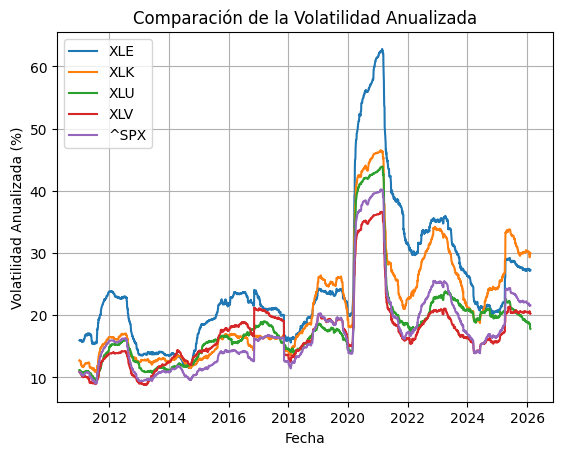

In [11]:
# Visualización de las desviaciones estándar anualizadas:
vol_rend_diario = rend_diario.rolling(252).std()*np.sqrt(252)*100
vol_rend_diario_spx = rend_diario_spx.rolling(252).std()*np.sqrt(252)*100
plt.plot(vol_rend_diario)
plt.plot(vol_rend_diario_spx)
plt.title('Comparación de la Volatilidad Anualizada')
plt.xlabel('Fecha')
plt.ylabel('Volatilidad Anualizada (%)')
plt.legend(vol_rend_diario.columns.append(vol_rend_diario_spx.columns), loc = "upper left")
plt.grid(True)
plt.show()

### **Métricas Estadísticas de los Activos Selecionados.**

In [12]:
# Cálculo de algunas estadísticas
media = rend_diario.mean()
desv_est = rend_diario.std()
matriz_cov = rend_diario.cov()

# Resumen de estadísticas de los activos elegidos
summary = pd.DataFrame({
    'Media': media,
    'Varianza': rend_diario.var(),
    'Desviación Estándar': desv_est,
    'Sesgo': rend_diario.skew(),
    'Curtosis': rend_diario.kurtosis()
})

print('\nResumen de Estadísticas de Rendimientos Diarios:')
print(summary)

print('\nMatríz de varianzas y covarianzas:')
print(matriz_cov)

print('\nMatríz de Correlación:')
print(rend_diario.corr())


Resumen de Estadísticas de Rendimientos Diarios:
           Media  Varianza  Desviación Estándar     Sesgo   Curtosis
Ticker                                                              
XLE     0.000495  0.000288             0.016962  0.137717  12.399164
XLK     0.000850  0.000209             0.014472  0.571862  13.298717
XLU     0.000538  0.000150             0.012252  0.948256  19.472255
XLV     0.000599  0.000130             0.011404  0.791719  12.589128

Matríz de varianzas y covarianzas:
Ticker       XLE       XLK       XLU       XLV
Ticker                                        
XLE     0.000288  0.000127  0.000087  0.000100
XLK     0.000127  0.000209  0.000093  0.000119
XLU     0.000087  0.000093  0.000150  0.000091
XLV     0.000100  0.000119  0.000091  0.000130

Matríz de Correlación:
Ticker       XLE       XLK       XLU       XLV
Ticker                                        
XLE     1.000000  0.518897  0.417174  0.515704
XLK     0.518897  1.000000  0.525252  0.721649
XLU   

### **Comparación de Desviaciones Estándar.**

In [13]:
desvs = round(pd.concat([desv_est, rend_diario_spx.std()], axis=0)*np.sqrt(252)*100, 2)
desvs.name = 'Desviación Estándar Total (Anualizada y Expresada en %)'
desvs

,Desviación Estándar Total (Anualizada y Expresada en %)
Ticker,
XLE,26.93
XLK,22.97
XLU,19.45
XLV,18.10
^SPX,18.48


### **Consulta y Descarga de los Datos de la Tasa de Referencia de Banxico desde 2010.**

In [14]:
# Código para conectarse a la API de BANXICO y obtener la tasa de referencia para la tasa libre de riesgo.

token = '0eb18fba71a0ef472c12a1923472556b62af8d82af7e923f3ee628e709df1492' # Token para usar la API
id = 'SF331451' # Id de la tasa de interés objetivo para la TIIE de Fondeo a un día

# Url de consulta, donde 'inicio' y 'hoy' son las fechas inicial y final declaradas al inicio de este documento:
url = f'https://www.banxico.org.mx/SieAPIRest/service/v1/series/{id}/datos/{inicio}/{fin}?token={token}'

# Obtenemos la serie de la tasa objetivo
response = requests.get(url)
if response.status_code == 200:
    datos = response.json()  # Convertir la respuesta en objeto de tipo JSON
    # Extraer datos de la serie
    series = datos['bmx']['series'][0]['datos']
    # Convertir en DataFrame
    tasa_referencia= pd.DataFrame(series) # DataFrame de la Tasa libre de riesgo (TIIE de Fondeo a Un Día)
    # Ajuste de formato
    tasa_referencia['fecha'] = pd.to_datetime(tasa_referencia['fecha'], format='%d/%m/%Y')  # Convertir la columna de fechas con el formato correcto
    tasa_referencia['dato'] = tasa_referencia['dato'].astype(float)  # Convertir los valores de tasas a float
    tasa_referencia.columns = ['Fecha', 'Tasa (Por ciento anual)'] # Renombrar las columnas del DataFrame

    print('Consulta llevada a cabo con éxito.')
else:
    print(f'Error en la solicitud: {response.status_code}')

Consulta llevada a cabo con éxito.


### **Tasa Libre de Riesgo.**

In [15]:
# Cálculo el promedio de la tasa libre de riesgo desde 2010
tasa_prom = tasa_referencia['Tasa (Por ciento anual)'].mean()
print(f"Tasa libre de riesgo: {round(tasa_prom,2)}% anual")

Tasa libre de riesgo: 6.16% anual


In [16]:
# Tasa libre de riesgo diaria:
tlr = (1+tasa_prom/100)**(1/252)-1

### **Implementación de Funciones para la Optimización de Portafolios.**

#### **Optimización bajo el criterio de Media-Varianza (Sin Restricciones).**

En este caso, la composcisión del portafolio que maximiza los rendimientos es:

$$
w^* = \frac{1}{λ}Σ^{-1}(\mu-r1)
$$

Donde:


*   $Σ$ es la matriz de varianzas y covarianzas
* $λ>0$ es el nivel de aversión al riesgo
* $μ$ es el vector de rendimientos promedio
* $r$ es la tasa libre de riesgo
* $1$ es un vector de 1's


In [17]:
# Función para Portafolio Optimo de media-varianza (Sin restricciones)
def portafolio_media_varianza(mu, sigma, tasa_libre_riesgo, aversion_riesgo):
  '''
  Función para obtener los pesos del portafolio óptimo según el criterio de media-varianza.
  Inputs:
  - mu: vector de rendimientos esperados (diarios)
  - sigma: matriz de varianzas y covarianzas (de tipo 'numpy')
  - tasa_libre_riesgo: tasa libre de riesgo (en decimal) diaria
  - aversion_riesgo: nivel de aversión al riesgo (cantidad positiva)

  Output:
  - w: vector de pesos del portafolio óptimo
  '''
  n = len(mu) # Número de activos: ETF´s + Activo Libre de Riesgo
  w = 1/aversion_riesgo * np.linalg.pinv(sigma)@(mu-tasa_libre_riesgo*np.ones(n))
  return w

#### **Optimización del portafolio usando el criterio de Media-Varianza (Con Restricción).**

En este caso, cuando se restringe a que la suma de los pesos sea $1$ (es decir, el $100\%$), la composcisión del portafolio que maximiza los rendimientos es:

$$
w^* = \frac{1}{λ}Σ^{-1}(\mu-r1)-\frac{1^TΣ^{-1}(\mu - r1)-\lambda}{\lambda 1^TΣ^{-1}1}Σ^{-1}1
$$


Donde:


* $Σ$ es la matriz de varianzas y covarianzas
* $λ>0$ es el nivel de aversión al riesgo
* $μ$ es el vector de rendimientos promedio
* $r$ es la tasa libre de riesgo
* $1$ es un vector de 1's

Nota: Vemos que el primer sumando de vector $w^*$ es el mismo que en el caso sin restricciones, de modo que el sugundo sumando es un término de ajuste para que los pesos sumen 1.

In [18]:
# Función para Portafolio Optimo de media-varianza
def portafolio_media_varianza_rest(mu, sigma, tasa_libre_riesgo, aversion_riesgo):
  '''
  Función para obtener los pesos del portafolio óptimo según el criterio de media-varianza cuando se restringe que la suma de los pesos sea igual a 1.
  Inputs:
  - mu: vector de rendimientos esperados (diarios)
  - sigma: matriz de varianzas y covarianzas (de tipo 'numpy')
  - tasa_libre_riesgo: tasa libre de riesgo (en decimal) diaria
  - aversion_riesgo: nivel de aversión al riesgo (cantidad positiva)

  Output:
  - w: vector de pesos del portafolio óptimo
  '''
  n = len(mu) # Número de activos: ETF´s + Activo Libre de Riesgo
  sigma_inv = np.linalg.pinv(sigma) # Inversa de la matríz de varianzas y covarianzas
  uno = np.ones(n) # Vector de 1´s de longitud n

  ajuste = (uno @ sigma_inv @ (mu-tasa_libre_riesgo*uno)-aversion_riesgo)/(aversion_riesgo*uno @ sigma_inv @ uno)*sigma_inv @ uno
  w = 1/aversion_riesgo * sigma_inv@(mu-tasa_libre_riesgo*uno) - ajuste
  return w

#### **Optimización sujeta a rendimiento definido.**

En este caso, el portafolio óptimo está compuesto por los pesos:

$$
w^* = \frac{1}{AC-B^2}Σ^{-1}[(A\mu-B1)m+(C1-B\mu)]
$$

Donde:
$$
A=1 ^T\Sigma^{-1} 1; B=\mu^{T}\Sigma^{-1} 1; C=\mu^{T}\Sigma^{-1}\mu
$$

In [19]:
# Funcion para Portafolio de minimizacion de riesgo con rendimiento del 13%:
def portafolio_min_riesgo(mu, sigma, nivel_rend_diario):
  '''
  Función para obtener los pesos del portafolio óptimo según el criterio de minimización de riesgo dado un nivel de rendimiento a alcanzar
  Inputs:
  - mu: vector de rendimientos esperados (diarios)
  - sigma: matriz de varianzas y covarianzas (de tipo 'numpy')
  - nivel_rend_diario: nivel de rendimiento convertido de forma diaria

  Output:
  - w: vector de pesos del portafolio óptimo
  '''
  n = len(mu) # Número de activos: ETF´s + Activo Libre de Riesgo
  sigma_inv = np.linalg.pinv(sigma) # Inversa de la matríz de varianzas y covarianzas
  uno = np.ones(n) # Vector de 1´s de longitud n

  A = uno @ sigma_inv @ uno # Coeficiente A
  B = mu @ sigma_inv @ uno # Coeficiente B
  C = mu @ sigma_inv@ mu  # Coeficiente C
  w = 1/(A*C-B**2) * sigma_inv @((A*mu - B*uno)*nivel_rend_diario + (C*uno - B*mu))
  return w

#### **Portafolios de Mímima Varianza y Tangente.**

Por un lado, el portafolio de mínima varianza tiene pesos:

$$
w_{g} = \frac{\Sigma^{-1} 1}{A}
$$

Por otro lado,  el portafolio tangente tiene pesos:

$$
w_{t} = \frac{Σ^{-1}(\mu - r1)}{B-Ar}
$$

Donde:
$$
A=1 ^T\Sigma^{-1} 1; B=\mu^{T}\Sigma^{-1} 1; C=\mu^{T}\Sigma^{-1}\mu
$$


In [20]:
def portafolio_min_var(sigma):
  '''
  Función para obtener los pesos del portafolio óptimo de mínima varianza.
  Inputs:
  - sigma: matriz de varianzas y covarianzas (de tipo 'numpy')

  Output
  - w: vector de pesos del portafolio óptimo
  '''
  n = len(sigma) # Número de activos: ETF´s + Activo Libre de Riesgo
  sigma_inv = np.linalg.pinv(sigma) # Inversa de la matríz de varianzas y covarianzas
  uno = np.ones(n) # Vector de 1´s de longitud n

  w = (sigma_inv @ uno)/(uno @ sigma_inv @ uno)
  return w

In [21]:
def portafolio_tangente(mu, sigma, tasa_libre_riesgo):
  '''
  Función para obtener los pesos del portafolio tangente.
  Inputs:
  - mu: vector de rendimientos esperados (diarios)
  - sigma: matriz de varianzas y covarianzas (de tipo 'numpy')
  - tasa_libre_riesgo: tasa libre de riesgo (en decimal) diaria

  Output:
  - w: vector de pesos del portafolio tangente
  '''
  n = len(mu) # Número de activos: ETF´s + Activo Libre de Riesgo
  sigma_inv = np.linalg.pinv(sigma) # Inversa de la matríz de varianzas y covarianzas
  uno = np.ones(n) # Vector de 1´s de longitud n
  A = uno @ sigma_inv @ uno # Coeficiente A
  B = mu @ sigma_inv @ uno # Coeficiente B

  w = (sigma_inv @ (mu - tasa_libre_riesgo*uno))/(B-A*tasa_libre_riesgo)
  return w

### **Resultados Obtenidos: Portafolios Óptimos**

In [22]:
# Niveles de Aversión al Riesgo Considerados para los Portafolios de Media-Varianza
nav = [0.5, 1, 5, 100]

#### **Caso 1.** Portafolio Sin Activo Libre de Riesgo

**Portafolio Optimo para 4 diferentes niveles de Aversión al Riesgo (Caso Sin Restricciones).**

---



In [23]:
# Composición del portafolio según el nivel de aversión al riesgo
portafolios = []
for i in range(len(nav)):
  portafolios.append(portafolio_media_varianza(media, matriz_cov, tlr, nav[i]))

In [24]:
# Presentación de Resultados: Composición de cada portafolio (expresada en porcentajes)
resultado = pd.DataFrame(portafolios, index = nav, columns = rend_diario.columns)
round(resultado*100, 2)

Ticker,XLE,XLK,XLU,XLV
0.5,-126.84,599.81,65.73,59.04
1.0,-63.42,299.90,32.86,29.52
5.0,-12.68,59.98,6.57,5.90
100.0,-0.63,3.00,0.33,0.30


In [25]:
# Suma de los pesos de cada portafolio anterior (porcentaje)
round(resultado.sum(axis=1)*100, 2)

,0
0.5,597.73
1.0,298.87
5.0,59.77
100.0,2.99


In [26]:
# Rendimiento esperado anual de cada composición (expresado en porcentaje)
((1 + (resultado).dot(media.values))**252 -1)*100

,0
0.5,267.663923
1.0,91.906946
5.0,13.940140
100.0,0.654810


**Portafolio Optimo para 4 diferentes niveles de Aversión al Riesgo (Caso Con Restricción).**

---


In [27]:
# Bajo los mismos niveles de aversión al riesgo, calculamos el portafolio óptimo
portafolios = []
for i in range(len(nav)):
  portafolios.append(portafolio_media_varianza_rest(media, matriz_cov, tlr, nav[i]))

In [28]:
# Presentación de Resultados: Composición de cada portafolio (expresada en porcentajes)
resultado = pd.DataFrame(portafolios, index = nav, columns = rend_diario.columns)
round(resultado*100, 2)

Ticker,XLE,XLK,XLU,XLV
0.5,-171.40,587.62,-119.19,-197.03
1.0,-81.23,295.03,-41.02,-72.79
5.0,-9.08,60.97,21.52,26.60
100.0,8.05,5.37,36.37,50.20


In [29]:
# Rendimiento esperado anual de cada composición (expresado en porcentaje)
((1 + (resultado).dot(media.values))**252 -1)*100

,0
0.5,79.634038
1.0,44.076241
5.0,20.752169
100.0,15.790092


**Portafolio Optimo para un rendimiento del 13% anual.**

---

In [30]:
nivel_rend = 0.13 # Nivel de rendimiento anual a alcanzar en el portafolio (Puedes cambiar este parámetro para ver qué pasa)
rendimiento_diario = (1+ nivel_rend)**(1/252)-1 # Conversión a rendimiento diario del nivel anterior

In [31]:
# Cálculo y Presentación del Portafolio
round((pd.DataFrame(portafolio_min_riesgo(media, matriz_cov , rendimiento_diario), index = rend_diario.columns, columns = ['Peso (en porcentaje)']))*100, 2)

,Peso (en porcentaje)
Ticker,
XLE,18.01
XLK,-26.94
XLU,45.00
XLV,63.92


**Portafolio de Mínima Varianza**

---


In [32]:
# Cálculo y Presentación del Portafolio
w = portafolio_min_var(matriz_cov) # Cálculo de los componentes
round((pd.DataFrame(w, index = rend_diario.columns, columns = ['Peso (en porcentaje)']))*100, 2) # Presentación

,Peso (en porcentaje)
Ticker,
XLE,8.95
XLK,2.45
XLU,37.15
XLV,51.45


In [33]:
# Rendimiento Esperado Anual del Portafolio
print(f'El rendimiento esperado del portafolio de mínima varianza es del {round(((1+np.dot(w, media))**252-1)*100, 2)}% anual.')

El rendimiento esperado del portafolio de mínima varianza es del 15.53% anual.


**Portafolio Tangente**

---

In [34]:
# Cálculo y Presentación del Portafolio
w = portafolio_tangente(media, matriz_cov, tlr) # Cálculo de los componentes
round((pd.DataFrame(w, index = rend_diario.columns, columns = ['Peso (en porcentaje)']))*100, 2) # Presentación

,Peso (en porcentaje)
Ticker,
XLE,-21.22
XLK,100.35
XLU,11.00
XLV,9.88


In [35]:
# Rendimiento Esperado Anual del Portafolio
print(f'El rendimiento esperado del portafolio tangente es del {round(((1+np.dot(w, media))**252-1)*100, 2)}% anual.')

El rendimiento esperado del portafolio tangente es del 24.39% anual.


### **Caso 2.** Portafolio Con Activo Libre de Riesgo

**Rendimientos diarios, vector de medias y matríz de covarianzas**

---

In [36]:
# Rendimientos diarios del Activo libre de riesgo
rend_diario_tlr = pd.DataFrame()
rend_diario_tlr['Date'] = tasa_referencia['Fecha']
rend_diario_tlr['Libre de Riesgo'] = (1+tasa_referencia['Tasa (Por ciento anual)']/100)**(1/252)-1
rend_diario_tlr = rend_diario_tlr.set_index('Date')

In [37]:
# Rendimientos diarios de la cartera incluyendo un activo libre de riesgo
rend_diario_ALR = rend_diario.join(rend_diario_tlr, how='outer')

In [38]:
# Rendimientos Esperados(mu) diarios:
media = rend_diario_ALR.mean()

In [39]:
# Matriz de varianzas y covarianzas (sigma) de los rendimientos diarios:
matriz_cov = rend_diario_ALR.cov()

**Portafolio Optimo para 4 diferentes niveles de Aversión al Riesgo (Caso Sin Restricciones).**

---



In [40]:
# Composición del portafolio según el nivel de aversión al riesgo
portafolios = []
for i in range(len(nav)):
  portafolios.append(portafolio_media_varianza(media, matriz_cov, tlr, nav[i]))

In [41]:
# Presentación de Resultados: Composición de cada portafolio (expresada en porcentajes)
resultado = pd.DataFrame(portafolios, index = nav, columns = rend_diario_ALR.columns)
round(resultado*100, 2)

,XLE,XLK,XLU,XLV,Libre de Riesgo
0.5,-127.67,607.60,66.31,48.01,-25890.96
1.0,-63.84,303.80,33.15,24.01,-12945.48
5.0,-12.77,60.76,6.63,4.80,-2589.10
100.0,-0.64,3.04,0.33,0.24,-129.45


In [42]:
# Suma de los pesos de cada portafolio anterior (porcentaje)
round(resultado.sum(axis=1)*100, 2)

,0
0.5,-25296.71
1.0,-12648.36
5.0,-2529.67
100.0,-126.48


In [43]:
# Rendimiento esperado anual de cada composición (expresado en porcentaje)
((1 + (resultado).dot(media.values))**252 -1)*100

,0
0.5,-99.999950
1.0,-99.921547
5.0,-75.681820
100.0,-6.808083


**Portafolio Optimo para 4 diferentes niveles de Aversión al Riesgo (Caso Con Restricción).**

---


In [44]:
# Bajo los mismos niveles de aversión al riesgo, calculamos el portafolio óptimo
portafolios = []
for i in range(len(nav)):
  portafolios.append(portafolio_media_varianza_rest(media, matriz_cov, tlr, nav[i]))

In [45]:
# Presentación de Resultados: Composición de cada portafolio (expresada en porcentajes)
resultado = pd.DataFrame(portafolios, index = nav, columns = rend_diario_ALR.columns)
round(resultado*100, 2)

,XLE,XLK,XLU,XLV,Libre de Riesgo
0.5,-126.68,600.01,66.49,59.87,-499.69
1.0,-63.34,299.99,33.24,29.96,-199.85
5.0,-12.66,59.97,6.65,6.03,40.01
100.0,-0.63,2.97,0.33,0.35,96.98


In [46]:
# Rendimiento esperado anual de cada composición (expresado en porcentaje)
((1 + (resultado).dot(media.values))**252 -1)*100

,0
0.5,174.270736
1.0,70.687803
5.0,16.718939
100.0,6.635717


**Portafolio Optimo para un rendimiento del 13% anual.**

---

In [47]:
nivel_rend = 0.13 # Nivel de rendimiento anual a alcanzar en el portafolio (Puedes cambiar este parámetro para ver qué pasa)
rendimiento_diario = (1+ nivel_rend)**(1/252)-1 # Conversión a rendimiento diario del nivel anterior

In [48]:
# Cálculo y Presentación del Portafolio
round((pd.DataFrame(portafolio_min_riesgo(media, matriz_cov , rendimiento_diario), index = rend_diario_ALR.columns, columns = ['Peso (en porcentaje)']))*100, 2)

,Peso (en porcentaje)
XLE,-8.35
XLK,39.54
XLU,4.39
XLV,3.99
Libre de Riesgo,60.43


**Portafolio de Mínima Varianza**

---


In [49]:
# Cálculo y Presentación del Portafolio
w = portafolio_min_var(matriz_cov) # Cálculo de los componentes
round((pd.DataFrame(w, index = rend_diario_ALR.columns, columns = ['Peso (en porcentaje)']))*100, 2) # Presentación

,Peso (en porcentaje)
XLE,0.00
XLK,-0.03
XLU,0.00
XLV,0.05
Libre de Riesgo,99.98


In [50]:
# Rendimiento Esperado Anual del Portafolio
print(f'El rendimiento esperado del portafolio de mínima varianza es del {round(((1+np.dot(w, media))**252-1)*100, 2)}% anual.')

El rendimiento esperado del portafolio de mínima varianza es del 6.13% anual.


**Portafolio Tangente**

---

In [51]:
# Cálculo y Presentación del Portafolio
w = portafolio_tangente(media, matriz_cov, tlr) # Cálculo de los componentes
round((pd.DataFrame(w, index = rend_diario_ALR.columns, columns = ['Peso (en porcentaje)']))*100, 2) # Presentación

,Peso (en porcentaje)
XLE,0.50
XLK,-2.40
XLU,-0.26
XLV,-0.19
Libre de Riesgo,102.35


In [52]:
# Rendimiento Esperado Anual del Portafolio
print(f'El rendimiento esperado del portafolio tangente es del {round(((1+np.dot(w, media))**252-1)*100, 2)}% anual.')

El rendimiento esperado del portafolio tangente es del 5.73% anual.
